# 7. Create a multi-class dataset using the spirals data creation function from CS231n (see below for the code).


Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).


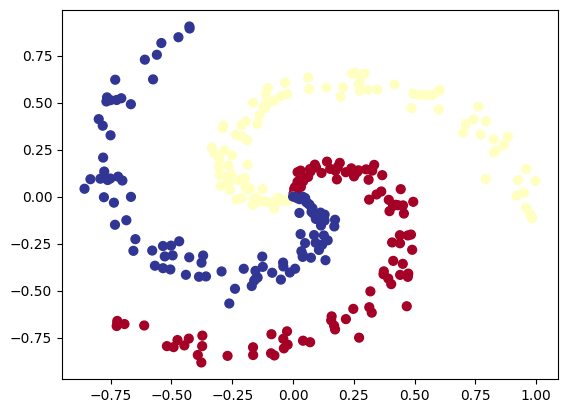

In [6]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from torchmetrics import Accuracy
from sklearn.model_selection import train_test_split
import numpy as np

# set up the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()
     

In [7]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

# Create train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
len(X_train), len(y_train), len(X_test), len(y_test)

(240, 240, 60, 60)

In [8]:
acc_fn = Accuracy(num_classes=3, task='multiclass').to(device)

In [10]:
# Our model

class SpiralModel(nn.Module):
	def __init__(self):
		super().__init__()
		self.linear1 = nn.Linear(in_features=2, out_features=10)
		self.linear2 = nn.Linear(in_features=10, out_features=10)
		self.linear3 = nn.Linear(in_features=10, out_features=3)
		self.relu = nn.ReLU()

	def forward(self, x):
		return self.linear3(self.relu(self.linear2(self.relu(self.linear1(x)))))

model = SpiralModel().to(device)
model

SpiralModel(
  (linear1): Linear(in_features=2, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=10, bias=True)
  (linear3): Linear(in_features=10, out_features=3, bias=True)
  (relu): ReLU()
)

In [14]:
# Set up the data to be device agnostic

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

print(X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype)

# Print untrained model outputs

print("Logits:")
print(model(X_test)[:10])

print("Pred probs:")
print(torch.softmax(model(X_test)[:10], dim=1))

print("Pred Labels")
print(torch.softmax(model(X_test)[:10], dim=1).argmax(dim=1))


torch.float32 torch.float32 torch.int64 torch.int64
Logits:
tensor([[-0.0439, -0.1006,  0.2078],
        [-0.0049, -0.0584,  0.1872],
        [-0.0578, -0.1154,  0.2198],
        [-0.0519, -0.1063,  0.2142],
        [-0.0288, -0.0843,  0.1884],
        [-0.0314, -0.0901,  0.1926],
        [-0.0628, -0.1246,  0.2168],
        [-0.0336, -0.0939,  0.2032],
        [-0.0473, -0.1035,  0.2119],
        [-0.0890, -0.1311,  0.2324]], grad_fn=<SliceBackward0>)
Pred probs:
tensor([[0.3095, 0.2924, 0.3981],
        [0.3165, 0.3000, 0.3835],
        [0.3064, 0.2892, 0.4044],
        [0.3075, 0.2912, 0.4013],
        [0.3136, 0.2967, 0.3897],
        [0.3131, 0.2952, 0.3917],
        [0.3065, 0.2881, 0.4054],
        [0.3117, 0.2934, 0.3949],
        [0.3085, 0.2917, 0.3998],
        [0.2996, 0.2872, 0.4132]], grad_fn=<SoftmaxBackward0>)
Pred Labels
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])


In [15]:
# Set up loss function and optimizer 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

In [18]:
# Training and testing loop

epochs = 1000

for epoch in range(epochs):
	### Training
	model.train()

	# Forward Pass
	y_logits = model(X_train)
	y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

	# Calculate the loss
	loss = loss_fn(y_logits, y_train)
	acc = acc_fn(y_pred, y_train)

	# Optimizer Zero Grad
	optimizer.zero_grad()

	# Loss backwards
	loss.backward()

	# Optimizer step
	optimizer.step()

	### Testing
	model.eval()
	with torch.inference_mode():
		# Forward Pass
		test_logits = model(X_test)
		test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

		# Calculate the loss
		test_loss = loss_fn(test_logits, y_test)
		test_acc = acc_fn(test_pred, y_test)

		if epoch % 100 == 0:
			print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {(acc*100):.2f}% | Test loss: {test_loss:.2f} Test acc: {(test_acc*100):.2f}%")


Epoch: 0 | Loss: 0.02 Acc: 99.17% | Test loss: 0.00 Test acc: 100.00%
Epoch: 100 | Loss: 0.01 Acc: 99.17% | Test loss: 0.00 Test acc: 100.00%
Epoch: 200 | Loss: 0.01 Acc: 99.17% | Test loss: 0.00 Test acc: 100.00%
Epoch: 300 | Loss: 0.01 Acc: 99.17% | Test loss: 0.00 Test acc: 100.00%
Epoch: 400 | Loss: 0.01 Acc: 99.17% | Test loss: 0.00 Test acc: 100.00%
Epoch: 500 | Loss: 0.01 Acc: 99.17% | Test loss: 0.00 Test acc: 100.00%
Epoch: 600 | Loss: 0.01 Acc: 99.17% | Test loss: 0.00 Test acc: 100.00%
Epoch: 700 | Loss: 0.01 Acc: 99.17% | Test loss: 0.00 Test acc: 100.00%
Epoch: 800 | Loss: 0.01 Acc: 99.17% | Test loss: 0.00 Test acc: 100.00%
Epoch: 900 | Loss: 0.01 Acc: 99.17% | Test loss: 0.00 Test acc: 100.00%


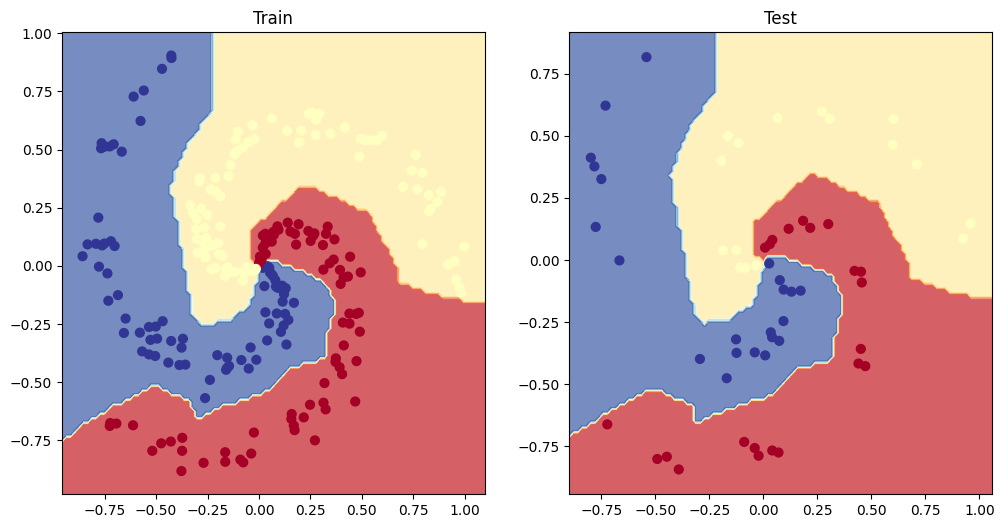

In [19]:
from helper_functions import plot_decision_boundary

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)